# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 

**Notebook 2: CNN Model Development**  
Aims:  
&nbsp; 1): Generate training and test images  
&nbsp; 2): Construct CNN models (a CNN model by own, Xception, VGG16, VGG19, Resnet, Inception, InceptionResnet)  
&nbsp; 3): Tune the hyperparameters of CNN models (hyperparameter optimization)  

## Import libraries

In [1]:
import os
import tensorflow
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from keras.preprocessing.image import load_img,img_to_array
import math
import random
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

2024-08-06 19:33:40.529802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-06 19:33:40.529830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Generate Training and Test Images

In [2]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 23383 images belonging to 5 classes.
Found 5845 images belonging to 5 classes.


### Define the image plotting functions

In [3]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [4]:
history_this= LossHistory()

# Construct CNN models

### Model 1: a CNN model by own (baseline)

In [5]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_own.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
    )
    

In [6]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()


2024-08-06 19:33:43.509015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 19:33:43.509399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 19:33:43.509746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-06 19:33:43.509816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-08-06 19:33:43.509884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9287 
Epoch 1: val_accuracy improved from -inf to 0.97690, saving model to ./model_own.h5
183/183 [==============================] - 2756s 15s/step - loss: 0.1965 - accuracy: 0.9287 - val_loss: 0.0463 - val_accuracy: 0.9769
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9726 
Epoch 2: val_accuracy did not improve from 0.97690
183/183 [==============================] - 2763s 15s/step - loss: 0.0545 - accuracy: 0.9726 - val_loss: 0.0551 - val_accuracy: 0.9618
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9729 
Epoch 3: val_accuracy improved from 0.97690 to 0.99076, saving model to ./model_own.h5
183/183 [==============================] - 2787s 15s/step - loss: 0.0526 - accuracy: 0.9729 - val_loss: 0.0328 - val_accuracy: 0.9908
Epoch 4/20
 25/183 [===>..........................] - ETA: 38:09 - loss: 0.0527 - acc

Validation accuracy of a CNN by own: 99.884%

### Model 2: Xception

In [ ]:

def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )


Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9911
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./xception.h5
183/183 [==============================] - 734s 4s/step - loss: 0.0306 - accuracy: 0.9911 - val_loss: 2.0679e-04 - val_accuracy: 1.0000
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 3.9335e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
183/183 [==============================] - 726s 4s/step - loss: 3.9335e-04 - accuracy: 1.0000 - val_loss: 5.0489e-05 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 2.0617e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 728s 4s/step - loss: 2.0617e-04 - accuracy: 1.0000 - val_loss: 2.3013e-05 - val_accuracy: 1.0000
Epoch 4/20
183/183 [==============================] - ETA: 0s - loss: 8.6677e-05 - accuracy: 1.0000
Epo

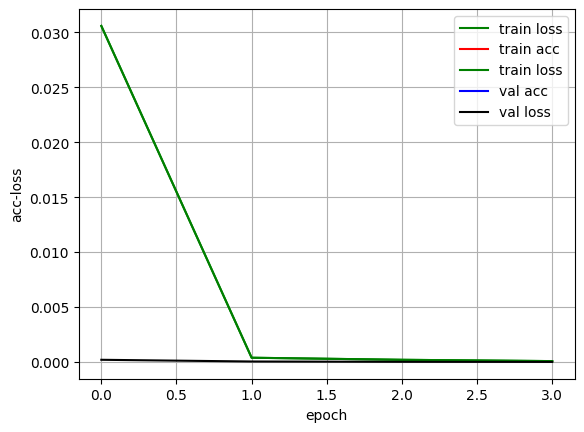

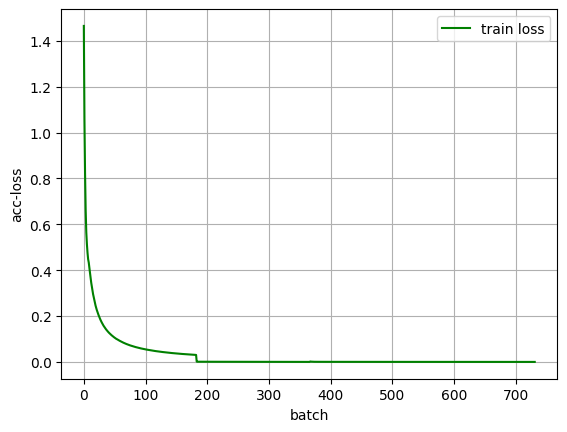

In [ ]:
#default only 50, tf36cnn 99
xception(num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Xception: 100.0%

### Model 3: VGG16

In [ ]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )


/usr/local/lib/python3.9/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9871
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./VGG16.h5
183/183 [==============================] - 1032s 6s/step - loss: 0.0435 - accuracy: 0.9871 - val_loss: 2.8553e-10 - val_accuracy: 1.0000
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9961
Epoch 2: val_accuracy did not improve from 1.00000
183/183 [==============================] - 1021s 6s/step - loss: 0.0651 - accuracy: 0.9961 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 1.8444e-07 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 1029s 6s/step - loss: 1.8444e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3: early stopping


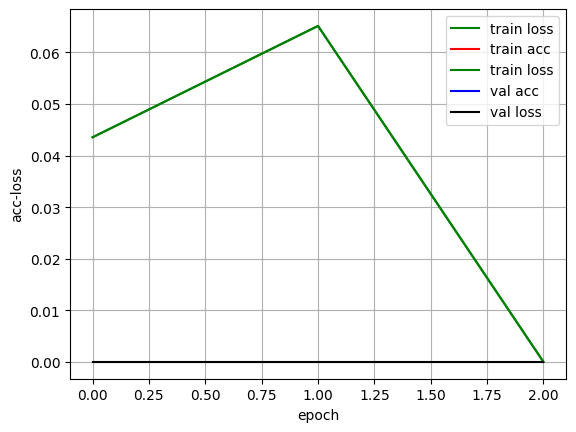

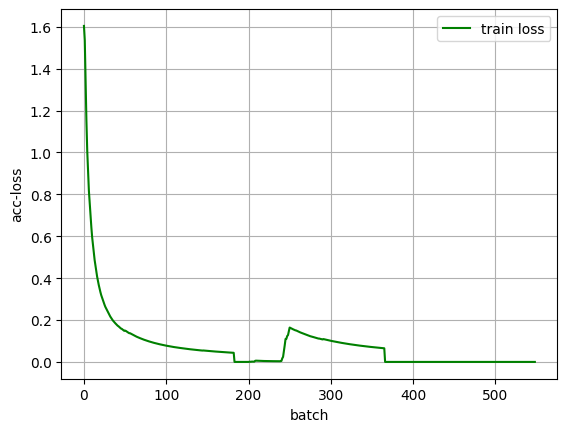

In [ ]:
vgg16(num_class=5,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG16: 100.0%

### Model 4: VGG19

In [ ]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )


2024-05-30 07:58:59.220386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 07:58:59.221047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 07:58:59.221687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-30 07:58:59.221834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-05-30 07:58:59.221974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

80150528/80134624 [==============================] - 5s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9922
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./VGG19.h5
183/183 [==============================] - 1138s 6s/step - loss: 0.0217 - accuracy: 0.9922 - val_loss: 1.9349e-05 - val_accuracy: 1.0000
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 2: val_accuracy did not improve from 1.00000
183/183 [==============================] - 1135s 6s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 2.3691e-06 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 8.2443e-06 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 1136s 6s/step - loss: 8.2443e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3: early stopping


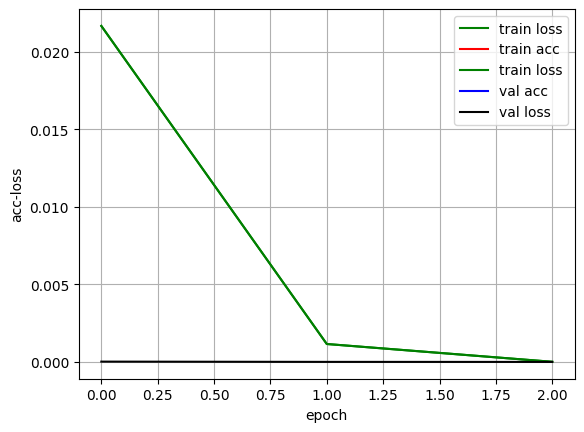

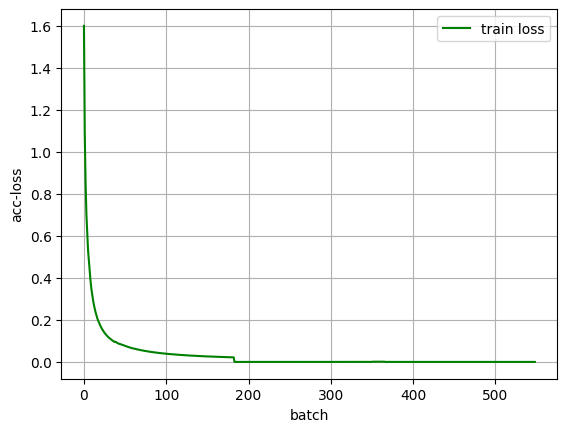

In [ ]:
vgg19(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG19: 100.0%

### Model 5: ResNet

In [ ]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

94781440/94765736 [==============================] - 4s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9616
Epoch 1: val_accuracy improved from -inf to 0.86416, saving model to ./resnet.h5
183/183 [==============================] - 1064s 6s/step - loss: 0.1183 - accuracy: 0.9616 - val_loss: 41.3367 - val_accuracy: 0.8642
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9984
Epoch 2: val_accuracy improved from 0.86416 to 0.90111, saving model to ./resnet.h5
183/183 [==============================] - 1050s 6s/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 20.1451 - val_accuracy: 0.9011
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 3: val_accuracy did not improve from 0.90111
183/183 [==============================] - 1049s 6s/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 4.2748 - val_accuracy: 0.9011
Epoch 4/20
183/183 [==========

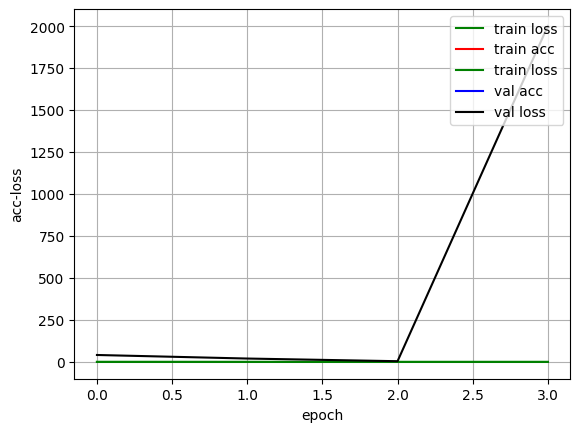

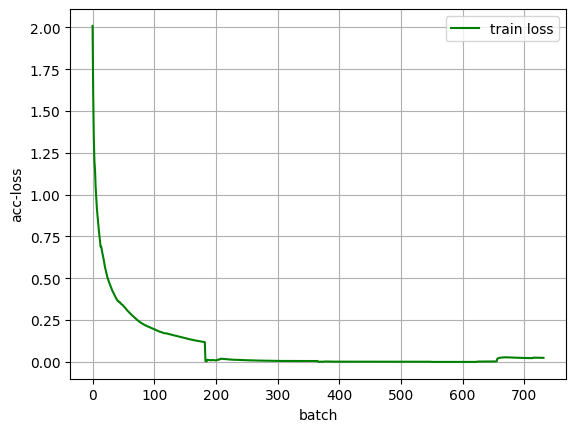

In [ ]:
resnet(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Resnet: 98.652%

### Model 6: Inception

In [ ]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

87924736/87910968 [==============================] - 5s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9907
Epoch 1: val_accuracy improved from -inf to 0.29495, saving model to ./inception.h5
183/183 [==============================] - 601s 3s/step - loss: 0.0330 - accuracy: 0.9907 - val_loss: 75.2259 - val_accuracy: 0.2950
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9967
Epoch 2: val_accuracy did not improve from 0.29495
183/183 [==============================] - 590s 3s/step - loss: 0.0335 - accuracy: 0.9967 - val_loss: 447.1223 - val_accuracy: 0.1624
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9987
Epoch 3: val_accuracy improved from 0.29495 to 1.00000, saving model to ./inception.h5
183/183 [==============================] - 592s 3s/step - loss: 0.0119 - accuracy: 0.9987 - val_loss: 9.7655e-07 - val_accuracy: 1.0000
Epoch 4/20
183/183 [==

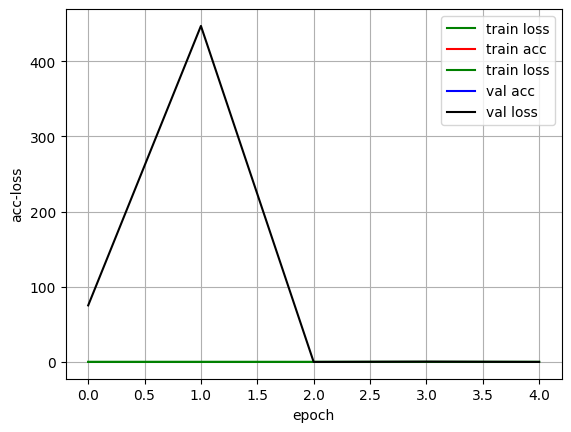

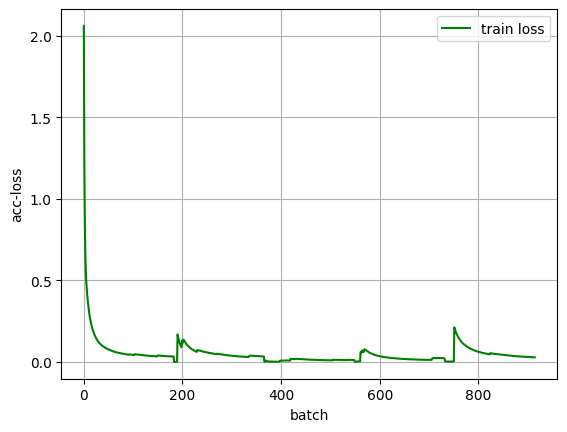

In [ ]:
inception(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Inception: 100.0%

### Model 7: InceptionResnet

In [ ]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

219070464/219055592 [==============================] - 10s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9890
Epoch 1: val_accuracy improved from -inf to 0.06450, saving model to ./inceptionresnet.h5
183/183 [==============================] - 930s 5s/step - loss: 0.0588 - accuracy: 0.9890 - val_loss: 88.6939 - val_accuracy: 0.0645
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9996
Epoch 2: val_accuracy improved from 0.06450 to 1.00000, saving model to ./inceptionresnet.h5
183/183 [==============================] - 917s 5s/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 4.8673e-05 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9997
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 916s 5s/step - loss: 0.0050 - accuracy: 0.9997 - val_loss: 1.0665e-05 - val_accuracy: 1.0000
Epoch

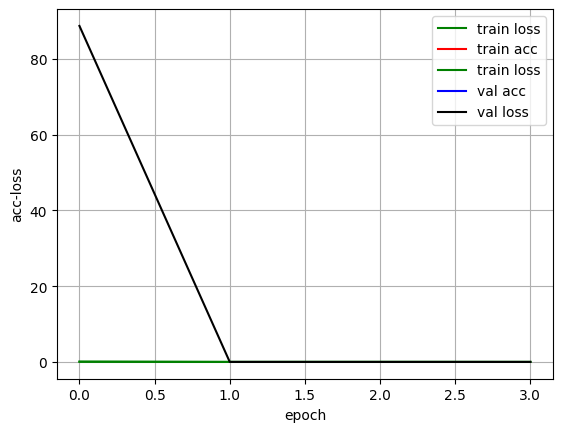

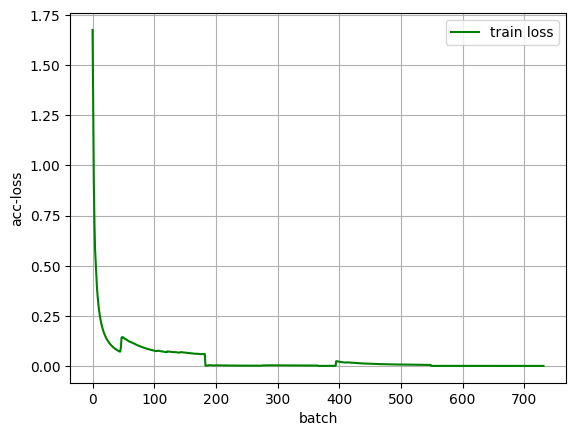

In [ ]:
inceptionresnet(num_class=5,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of InceptionResnet: 99.993%

# Hyperparameter Optimization 
Use VGG16 as an example.  

Tuned hyperparameters of CNN: 
1. The number of frozen layers
2. The number of epochs
3. Early stop patience
4. Learning rate
5. Dropout rate

Hyperparameter optimization methods:
1. Random search
2. Bayesian optimization - Tree Parzen Estimator(BO-TPE)

In [ ]:
def vgg16( num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0, savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = tensorflow.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
        verbose = verbose
    )
    return hist


In [ ]:
def prediction(vgg_model):
#read images from validation folder
    rootdir = './test_224/'
    test_laels = []
    test_images=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
                continue
            test_laels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict=[]
    length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
        res=label[np.argmax(vgg_model_batch,axis=1)[0]]
        predict.append(res)
    acc=accuracy_score(test_laels,predict)
    return acc

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen=params['frozen']
    epochs=params['epochs']
    patience=params['patience']
    lr=params['lr']
    dropout_rate=params['dropout_rate']

    vgg16(num_class=5, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    acc=prediction(vgg_model=load_model('./VGG16.h5'))

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

accuracy:1.0                                          
accuracy:1.0                                                             
accuracy:1.0                                                             
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
100%|██████████| 10/10 [10:48:44<00:00, 3892.41s/trial, best loss: -1.0] 
Hyperopt estimated optimum {'dropout_rate': 0.30000000000000004, 'epochs': 20.0, 'frozen': 16.0, 'lr': 0.003, 'patience': 3.0}
Time: 38924.15103602409


In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

accuracy:1.0                                          
accuracy:1.0                                                             
accuracy:1.0                                                             
accuracy:1.0                                                             
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                            
accuracy:1.0                                                             
100%|██████████| 10/10 [11:42:18<00:00, 4213.88s/trial, best loss: -1.0] 
Hyperopt estimated optimum {'dropout_rate': 0.5, 'epochs': 20.0, 'frozen': 16.0, 'lr': 0.005, 'patience': 4.0}
Time: 42138.81503009796


In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
vgg16(num_class=5, frozen=16,epochs=20,patience=4, lr=0.005, dropout_rate=0.5,verbose=1)

Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.9598
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./VGG16.h5
183/183 [==============================] - 944s 5s/step - loss: 0.3599 - accuracy: 0.9598 - val_loss: 7.4401e-08 - val_accuracy: 1.0000
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 2.3006e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
183/183 [==============================] - 944s 5s/step - loss: 2.3006e-05 - accuracy: 1.0000 - val_loss: 3.0817e-08 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 8.5194e-06 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 944s 5s/step - loss: 8.5194e-06 - accuracy: 1.0000 - val_loss: 1.3869e-08 - val_accuracy: 1.0000
Epoch 4/20
183/183 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9966
Epoch 4: v